In [2]:
from pathlib import Path
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle, json
from collections import defaultdict
cwd = Path(os.getcwd())
WORKING_DIR = cwd.parent
DATASET_DIR = WORKING_DIR.parent / "dataset"

from gprofiler import GProfiler

In [3]:
# preds_path = cwd / "analysis_results/m5C_predictions.tsv.gz"
# preds = pd.read_csv(preds_path, sep="\t", compression="gzip")
# preds["gene_id"] = preds["gene_id"].apply(lambda x: x.split(".")[0])

# tx_file = cwd / "transcriptome/gencode_customized.tsv"
# tx = pd.read_csv(tx_file, sep="\t")
# tx["gene_id"] = tx["gene_id"].apply(lambda x: x.split(".")[0])
# background = list(set(tx["gene_id"].unique()))

# # Safe way to check for substring that handles non-string values
# def check_tag(x):
#     if isinstance(x, str):
#         return "Ensembl_canonical" in x
#     return False  # Return False for non-string values

# preds["is_canonical"] = preds["tag"].apply(check_tag)

In [4]:
# preds = preds.loc[(preds["in_train_or_test_sets"] == False) & (preds["is_canonical"] == True)]
# classes = {}
# for class_ in preds["Type"].unique():
#     type_now = preds[preds["Type"] == class_].sort_values(by="probability", ascending=False)
#     classes[class_] = type_now.copy()


In [5]:
# # ---------- size‑range + evidences + redundancy filter ----------
# def simplify_by_overlap(df, cutoff=0.75):
#     df = df.sort_values("p_value")
#     kept, gene_sets = [], []
#     for idx, row in df.iterrows():
#         genes = set(row["intersections"])   # now exists
#         if all(len(genes & gs) / len(genes | gs) < cutoff for gs in gene_sets):
#             kept.append(idx)
#             gene_sets.append(genes)
#     return df.loc[kept]

# SOURCES = ["HP", "GO:BP", "GO:MF", "GO:CC", "REAC", "KEGG", "CORUM"]
# gp = GProfiler(return_dataframe=True)
# slims_all = {}
# raws_all = {}

# n_mods = 1000
# significance_threshold_method = "fdr"  # or "fdr", "g_SCS", etc.

# for cls, df_now in classes.items():
#     raws = {}
#     slims = {}

#     genes = df_now.iloc[:n_mods]["gene_id"].unique().tolist()
    
#     for src in SOURCES:
#         raw = gp.profile(
#             organism   = "hsapiens",
#             query      = genes,
#             background = background,
#             sources    = [src],
#             user_threshold = 0.05,
#             significance_threshold_method = significance_threshold_method,
#             no_evidences = False            # ← include intersections column
#         )

#         # keep reasonable term sizes (20–500)
#         raw = raw[raw.term_size.between(20, 500)]
#         if raw.empty:
#             continue
        
#         raws[src] = raw

#     raws_all[cls] = raws



# all_slims_70 = {}
# all_slims_50 = {}
# all_slims_30 = {}
# for cls, raws in raws_all.items():
#     all_slims_70[cls] = {}
#     all_slims_50[cls] = {}
#     all_slims_30[cls] = {}
#     for src, raw in raws.items():
#         slim_70 = simplify_by_overlap(raw, cutoff=0.70)
#         all_slims_70[cls][src] = slim_70
#         slim_50 = simplify_by_overlap(raw, cutoff=0.50)
#         all_slims_50[cls][src] = slim_50
#         slim_30 = simplify_by_overlap(raw, cutoff=0.30)
#         all_slims_30[cls][src] = slim_30
        

In [6]:
# # Create main results directory
# results_dir = cwd / f"enrichment_results/number_of_modifications_{n_mods}_{significance_threshold_method}"
# results_dir.mkdir(parents=True, exist_ok=True)

# # Save raw results
# for cls, raws in raws_all.items():
#     class_dir = results_dir / cls
#     class_dir.mkdir(exist_ok=True)
    
#     for src, raw_df in raws.items():
#         src_dir = class_dir / src
#         src_dir.mkdir(exist_ok=True)
        
#         # Save raw results
#         raw_dir = src_dir / "raw"
#         raw_dir.mkdir(exist_ok=True)
#         raw_df.to_csv(raw_dir / "enrichment_results.csv", index=False)

# # Save slim results for all thresholds
# threshold_data = {
#     "70": all_slims_70,
#     "50": all_slims_50, 
#     "30": all_slims_30
# }

# for threshold, slims_dict in threshold_data.items():
#     for cls, slims in slims_dict.items():
#         class_dir = results_dir / cls
        
#         for src, slim_df in slims.items():
#             src_dir = class_dir / src
            
#             # Save slim results
#             slim_dir = src_dir / f"slim_{threshold}"
#             slim_dir.mkdir(exist_ok=True)
#             slim_df.to_csv(slim_dir / "enrichment_results.csv", index=False)

# print(f"Results saved to: {results_dir}")

# # Optional: Also save the dictionaries as pickle files for easy loading
# with open(results_dir / "raws_all.pickle", "wb") as f:
#     pickle.dump(raws_all, f)

# with open(results_dir / "all_slims_70.pickle", "wb") as f:
#     pickle.dump(all_slims_70, f)
    
# with open(results_dir / "all_slims_50.pickle", "wb") as f:
#     pickle.dump(all_slims_50, f)
    
# with open(results_dir / "all_slims_30.pickle", "wb") as f:
#     pickle.dump(all_slims_30, f)

# print("Pickle files also saved for easy loading")

In [7]:
path = Path("./enrichment_results/number_of_modifications_1000_fdr/all_slims_50.pickle")
with open(path, "rb") as f:
    all_slims_50 = pickle.load(f)

SOURCE = "KEGG" # ["HP", "GO:BP", "GO:MF", "GO:CC", "REAC", "KEGG", "CORUM"]

map_ = {"I": "NSUN2",
        "II": "NSUN6",
        "III": "NSUN5",
        "IV": "NSUN1"}

In [8]:
def standardize_labels(df, max_width=45):
    """Ensure all labels have similar visual width"""
    df["label"] = [textwrap.shorten(s, max_width, placeholder="…").rjust(max_width) 
                   for s in df.name]
    return df

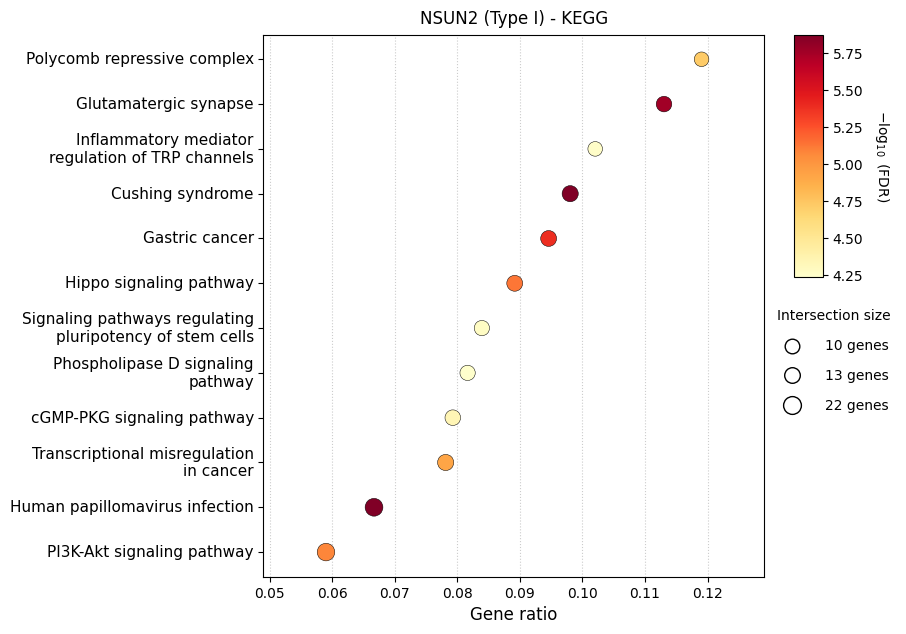

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np, textwrap

def create_two_line_labels(df, max_chars_per_line=25):
    """Split labels into two lines with smart wrapping"""
    labels = []
    for name in df.name:
        if len(name) <= max_chars_per_line:
            # Short enough for one line
            labels.append(name)
        else:
            # Need to split into two lines
            words = name.split()
            line1, line2 = "", ""
            
            # Build first line
            for word in words:
                if len(line1 + " " + word) <= max_chars_per_line:
                    line1 += (" " + word) if line1 else word
                else:
                    # Start second line with remaining words
                    remaining_words = words[words.index(word):]
                    line2 = " ".join(remaining_words)
                    break
            
            # Truncate second line if too long
            if len(line2) > max_chars_per_line:
                line2 = textwrap.shorten(line2, max_chars_per_line, placeholder="…")
            
            # Combine with newline
            labels.append(f"{line1}\n{line2}")
    
    return labels

# ────────────────── sample table, as in your pipeline ──────────────────
top_n   = 12
source  = "KEGG"
cls     = "I"

df = (all_slims_50[cls][source]          # already slimmed & size‑filtered
        .nsmallest(top_n, "p_value")
        .assign(gene_ratio = lambda d: d.intersection_size/d.term_size,
                logFDR     = lambda d: -np.log10(d.p_value))
        .sort_values("gene_ratio", ascending=False)
        .reset_index(drop=True))

# Create two-line labels instead of standardized labels
df["label"] = create_two_line_labels(df, max_chars_per_line=30)

y          = np.arange(len(df))[::-1]
dot_sizes  = np.sqrt(df.intersection_size)*35          # perceptually linear
dot_colors = df.logFDR                                 # colour = –log₁₀ FDR

# ───────────────────────────  layout  ─────────────────────────────────
fig      = plt.figure(figsize=(7.6, 0.47*top_n + 1.4))
spec = gs.GridSpec(nrows=20, ncols=20,
                   wspace=0.01, hspace=0.1)

# Main plot spans both rows of the left column
ax_main = fig.add_subplot(spec[:, :17])  # All rows, first column

# Right side split into two halves
ax_cbar = fig.add_subplot(spec[0:9, 18:19])  # Upper right
ax_size = fig.add_subplot(spec[10:14, 17:19])  

# ---- main scatter ----------------------------------------------------
sc = ax_main.scatter(df.gene_ratio, y, s=dot_sizes, c=dot_colors,
                     cmap="YlOrRd", edgecolors="k", linewidths=.35)

# ax_main.set_xlim(0.05, 0.14)
ax_main.set_xlim(df.gene_ratio.min()-0.01, df.gene_ratio.max()+0.01)
ax_main.set_yticks(y)
ax_main.set_yticklabels(df.label, fontsize=11, va='center')  # Added va='center' for better alignment
ax_main.set_xlabel("Gene ratio", fontsize=12)
ax_main.set_title(f"{map_[cls]} (Type {cls}) - {source}", pad=8)
ax_main.grid(axis="x", ls=":", color="0.8")
ax_main.set_axisbelow(True)

# ---- colour‑bar occupies its own, fixed column -----------------------
cbar = fig.colorbar(sc, cax=ax_cbar)
cbar.set_label(r"$-\log_{10}$ (FDR)", fontsize=10, rotation=270, labelpad=20)

# ---- intersection‑size legend in a dedicated blank axis --------------
ax_size.set_axis_off()

sizes_ref = np.array([df.intersection_size.min(),
                      df.intersection_size.median(),
                      df.intersection_size.max()], dtype=int)

handles = [plt.scatter([], [], s=np.sqrt(s)*35, edgecolors="k",
                       facecolors="w") for s in sizes_ref]
labels  = [f"{s} genes" for s in sizes_ref]

ax_size.legend(handles, labels, title="Intersection size",
               loc="center left", frameon=False, labelspacing=1.15,
               handletextpad=1.4)

source_name = source.replace(":", "")  # remove colon for file naming
# plt.savefig(cwd / f"enrichment_results/type_{cls}_{source_name}_enrichment.pdf", bbox_inches="tight")
plt.savefig(cwd / f"enrichment_results/type_{cls}_{source_name}_enrichment.eps", bbox_inches="tight")

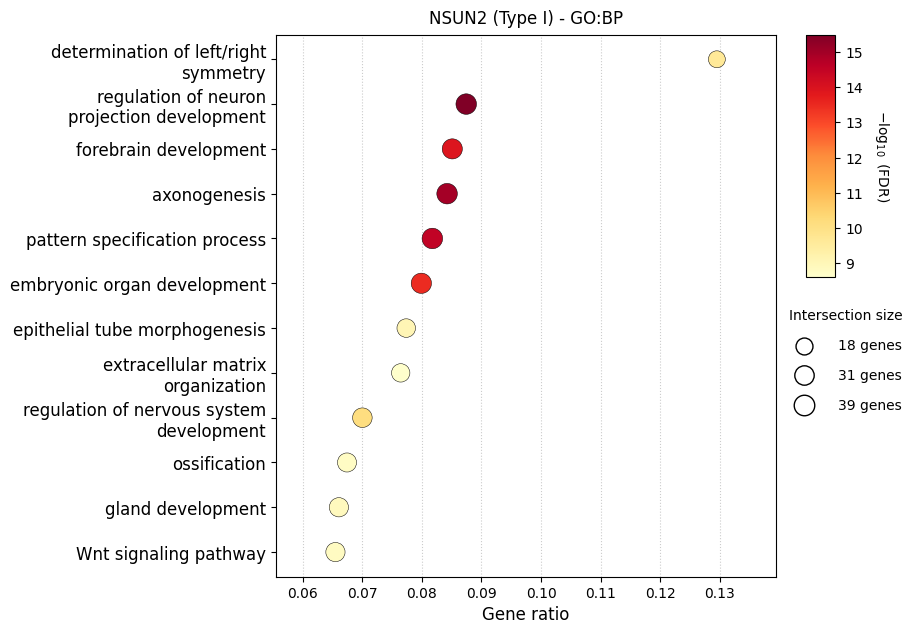

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np, textwrap

# ────────────────── sample table, as in your pipeline ──────────────────
top_n   = 12
source  = "GO:BP"
cls     = "I"

df = (all_slims_50[cls][source]          # already slimmed & size‑filtered
        .nsmallest(top_n, "p_value")
        .assign(gene_ratio = lambda d: d.intersection_size/d.term_size,
                logFDR     = lambda d: -np.log10(d.p_value))
        .sort_values("gene_ratio", ascending=False)
        .reset_index(drop=True))

# df["label"] = [textwrap.shorten(s, 55, placeholder="…") for s in df.name]
df["label"] = create_two_line_labels(df, max_chars_per_line=30)

y          = np.arange(len(df))[::-1]
dot_sizes  = np.sqrt(df.intersection_size)*35          # perceptually linear
dot_colors = df.logFDR                                 # colour = –log₁₀ FDR

# ───────────────────────────  layout  ─────────────────────────────────
fig      = plt.figure(figsize=(7.6, 0.47*top_n + 1.4))
spec = gs.GridSpec(nrows=20, ncols=20,
                #    width_ratios=[10, 10],        # 75% vs 25% width split
                #    height_ratios=[10, 10],       # Equal height split for right side
                   wspace=0.01, hspace=0.1)

# Main plot spans both rows of the left column
ax_main = fig.add_subplot(spec[:, :17])  # All rows, first column

# Right side split into two halves
ax_cbar = fig.add_subplot(spec[0:9, 18:19])  # Upper right
ax_size = fig.add_subplot(spec[10:14, 17:19])  

# ---- main scatter ----------------------------------------------------
sc = ax_main.scatter(df.gene_ratio, y, s=dot_sizes, c=dot_colors,
                     cmap="YlOrRd", edgecolors="k", linewidths=.35)

ax_main.set_xlim(df.gene_ratio.min()-0.01, df.gene_ratio.max()+0.01)          # 15 % head‑room
# ax_main.set_xlim(0.05, 0.14)          # 15 % head‑room
ax_main.set_yticks(y)
ax_main.set_yticklabels(df.label, fontsize=12)
ax_main.set_xlabel("Gene ratio", fontsize=12)
ax_main.set_title(f"{map_[cls]} (Type {cls}) - {source}", pad=8)
ax_main.grid(axis="x", ls=":", color="0.8")
ax_main.set_axisbelow(True)

# ---- colour‑bar occupies its own, fixed column -----------------------
cbar = fig.colorbar(sc, cax=ax_cbar)
cbar.set_label(r"$-\log_{10}$ (FDR)", fontsize=10, rotation=270, labelpad=20)

# ---- intersection‑size legend in a dedicated blank axis --------------
ax_size.set_axis_off()

sizes_ref = np.array([df.intersection_size.min(),
                      df.intersection_size.median(),
                      df.intersection_size.max()], dtype=int)

handles = [plt.scatter([], [], s=np.sqrt(s)*35, edgecolors="k",
                       facecolors="w") for s in sizes_ref]
labels  = [f"{s} genes" for s in sizes_ref]

ax_size.legend(handles, labels, title="Intersection size",
               loc="center left", frameon=False, labelspacing=1.15,
               handletextpad=1.4)

source_name = source.replace(":", "")  # remove colon for file naming
# plt.savefig(cwd / f"enrichment_results/type_{cls}_{source_name}_enrichment.pdf", bbox_inches="tight")
plt.savefig(cwd / f"enrichment_results/type_{cls}_{source_name}_enrichment.eps", bbox_inches="tight")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np, textwrap, pickle
from pathlib import Path

# ───────────────────────────  INPUTS  ──────────────────────────
CLASS      = "IV"                                   # "I" | "II" | "III" | "IV"
SOURCES    = ["GO:BP", "GO:MF",  "GO:CC", "REAC", "KEGG", "HP"] 
TOP_N      = 12                                    # top terms per panel


NAME_MAP = {"I": "NSUN2", "II": "NSUN6", "III": "NSUN5", "IV": "NSUN1"}



def prep_df(source):
    df = (all_slims_50[CLASS][source]          # already slimmed & size‑filtered
            .nsmallest(TOP_N, "p_value")
            .assign(gene_ratio=lambda d: d.intersection_size / d.term_size,
                    logFDR    =lambda d: -np.log10(d.p_value))
            .sort_values("gene_ratio", ascending=False)
            .reset_index(drop=True))
    df["label"] = create_two_line_labels(df, max_chars_per_line=30) #[textwrap.shorten(s, 45, placeholder="…") for s in df.name]
    return df

# pre‑compute once (min/med/max intersection sizes for legends)
size_refs = {}
for src in SOURCES:
    s = prep_df(src).intersection_size
    size_refs[src] = (int(s.min()), int(s.median()), int(s.max()))

# ───────────────────────────  FIGURE  ──────────────────────────
fig = plt.figure(figsize=(20, 27))
outer = gs.GridSpec(3, 2, wspace=0.5, hspace=0.2)
outers = [x for x in outer]  # flatten outer
for k, source in enumerate(SOURCES):
    row, col = divmod(k, 2)
    subspec  = outers[k].subgridspec(nrows=20, ncols=20,
                                           wspace=0.01, hspace=0.1)
    ax_main  = fig.add_subplot(subspec[:, :17])
    ax_cbar  = fig.add_subplot(subspec[0:9, 18:19])
    ax_legen = fig.add_subplot(subspec[10:14, 19:20])
    ax_legen.set_axis_off()

    df   = prep_df(source)
    y    = np.arange(len(df))[::-1]
    dots = np.sqrt(df.intersection_size) * 35      # ✓ same scaling
    sc   = ax_main.scatter(df.gene_ratio, y,
                           s=dots,
                           c=df.logFDR,
                           cmap="viridis_r",
                           edgecolors="k",
                           linewidths=.35)

    ax_main.set_xlim(df.gene_ratio.min() - 0.01,
                     df.gene_ratio.max() + 0.01)
    ax_main.set_yticks(y)
    ax_main.set_yticklabels(df.label, fontsize=11)
    ax_main.set_xlabel("Gene ratio", fontsize=12)
    ax_main.set_title(f"{NAME_MAP[CLASS]} (Type {CLASS}) – {source}",
                      fontsize=13, pad=6)
    ax_main.grid(axis="x", ls=":", color="0.80")
    ax_main.set_axisbelow(True)

    # colour‑bar
    cbar = fig.colorbar(sc, cax=ax_cbar)
    cbar.set_label(r"$-\log_{10}$ (FDR)", fontsize=10, rotation=270, labelpad=20)

    # size legend
    smin, smed, smax = size_refs[source]
    handles = [plt.scatter([], [], s=np.sqrt(s)*35, edgecolors="k",
                           facecolors="w") for s in (smin, smed, smax)]
    labels  = [f"{s} genes" for s in (smin, smed, smax)]
    ax_legen.legend(handles, labels, title="Intersection size",
                    loc="center", frameon=False,
                    handletextpad=1.4, labelspacing=1.2)



# out = (cwd / f"enrichment_results/Type_{CLASS}_4panel.pdf").resolve()
out = (cwd / f"enrichment_results/Type_{CLASS}_4panel.eps").resolve()
fig.savefig(out, bbox_inches="tight")
print("Saved:", out)
